# Simulation using Concord

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import scanpy as sc
import time
from pathlib import Path
import torch
import Concord as ccd
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [3]:
proj_name = "simulation_ccd_manifoldS"
save_dir = f"../save/dev_{proj_name}-{time.strftime('%b%d')}/"
save_dir = Path(save_dir)
save_dir.mkdir(parents=True, exist_ok=True)

data_dir = f"../data/{proj_name}/"
data_dir = Path(data_dir)
data_dir.mkdir(parents=True, exist_ok=True)
device = torch.device('cuda:3' if torch.cuda.is_available() else 'cpu')
print(device)
seed = 0
ccd.ul.set_seed(seed)

cuda:3


In [4]:
import matplotlib.pyplot as plt

# unused but required import for doing 3d projections with matplotlib < 3.2
import mpl_toolkits.mplot3d  # noqa: F401
from matplotlib import ticker

from sklearn import datasets, manifold

n_samples = 1000
S_points, S_color = datasets.make_s_curve(n_samples, random_state=0)

In [5]:
from Concord.utils.simulation import Simulation
#group_key = 'group'
group_key = 'time'
batch_key = 'batch'
state_type = 's_curve'
batch_type = 'batch_specific_features'
distribution = 'normal'
# Create an instance of the Simulation class
file_suffix = f"{state_type}_{batch_type}_{distribution}_{time.strftime('%b%d-%H%M')}"

sim = Simulation(n_cells=1000, n_genes=200, n_batches=2, n_states=3, 
                 state_type=state_type, 
                 state_distribution = distribution, 
                 state_level=2, 
                 state_min_level=0,
                 state_dispersion=1.0, 
                 program_structure='linear',
                 program_on_time_fraction=0.0,
                 trajectory_program_num=4,
                 trajectory_loop_to=1,
                 tree_branching_factor=2,
                 tree_depth=2,
                 tree_program_decay=0.7,
                 batch_distribution=distribution,
                 batch_type=batch_type, 
                 batch_level=[2,2], 
                 batch_dispersion=[1.0, 1.0], 
                 universal_gene_fraction=0.1,
                 non_neg=True, to_int=True,
                 seed=42)

# Generate the simulated data
adata, adata_state = sim.simulate_data()
adata.layers['counts'] = adata.X.copy()
file_suffix = f"{state_type}_{batch_type}_{distribution}_{time.strftime('%b%d-%H%M')}"


Concord.utils.simulation - INFO - Simulating S-curve with distribution: normal with mean shift 2 and dispersion 1.0.
Concord.utils.simulation - INFO - Simulating batch-specific features effect on batch_1 by appending a set of batch-specific genes with normal distributed value with level 2 and dispersion 1.0.
Concord.utils.simulation - INFO - Simulating batch-specific features effect on batch_2 by appending a set of batch-specific genes with normal distributed value with level 2 and dispersion 1.0.


In [6]:
# Order adata and adata_state by time
adata_state = adata_state[adata_state.obs['time'].argsort()]
adata = adata[adata.obs['time'].argsort()]


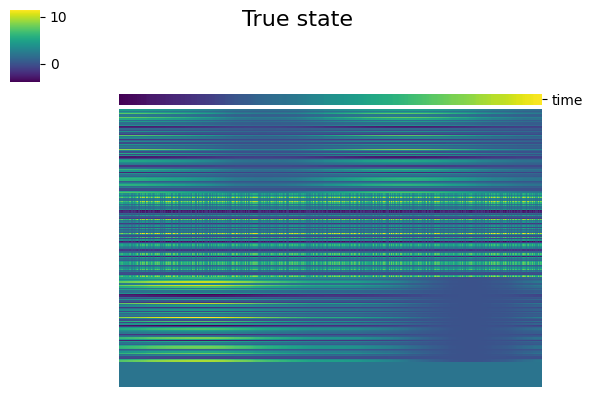

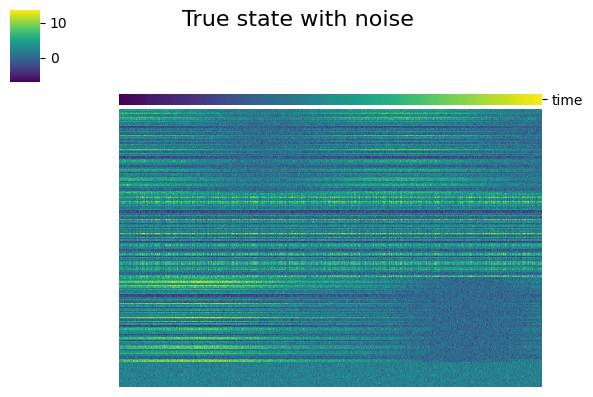

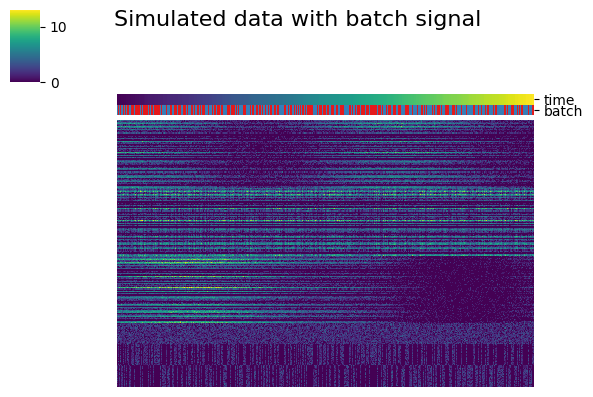

In [7]:
ccd.pl.heatmap_with_annotations(adata_state, val='no_noise', obs_keys=[group_key], yticklabels=False, cluster_cols=False, cluster_rows=False, value_annot=False, cmap='viridis', title='True state', save_path=save_dir/f'true_state_heatmap_{file_suffix}.png', figsize=(6, 4), dpi=300)
ccd.pl.heatmap_with_annotations(adata_state, val='wt_noise', obs_keys=[group_key], yticklabels=False, cluster_cols=False, cluster_rows=False, value_annot=False, cmap='viridis', title='True state with noise', save_path=save_dir/f'true_state_with_noise_heatmap_{file_suffix}.png', figsize=(6, 4), dpi=300)
ccd.pl.heatmap_with_annotations(adata, val='X', obs_keys=[group_key, batch_key], yticklabels=False, cluster_cols=False, cluster_rows=False, value_annot=False, cmap='viridis', title='Simulated data with batch signal', save_path=save_dir/f'simulated_data_heatmap_{file_suffix}.png', figsize=(6, 4), dpi=300)

### NO batch effect, PCA and UMAP

In [131]:
ccd.ul.run_pca(adata_state, source_key='no_noise', result_key='PCA_no_noise', n_pc=30, random_state=seed)
ccd.ul.run_umap(adata_state, source_key='PCA_no_noise', result_key='UMAP_no_noise', random_state=seed)

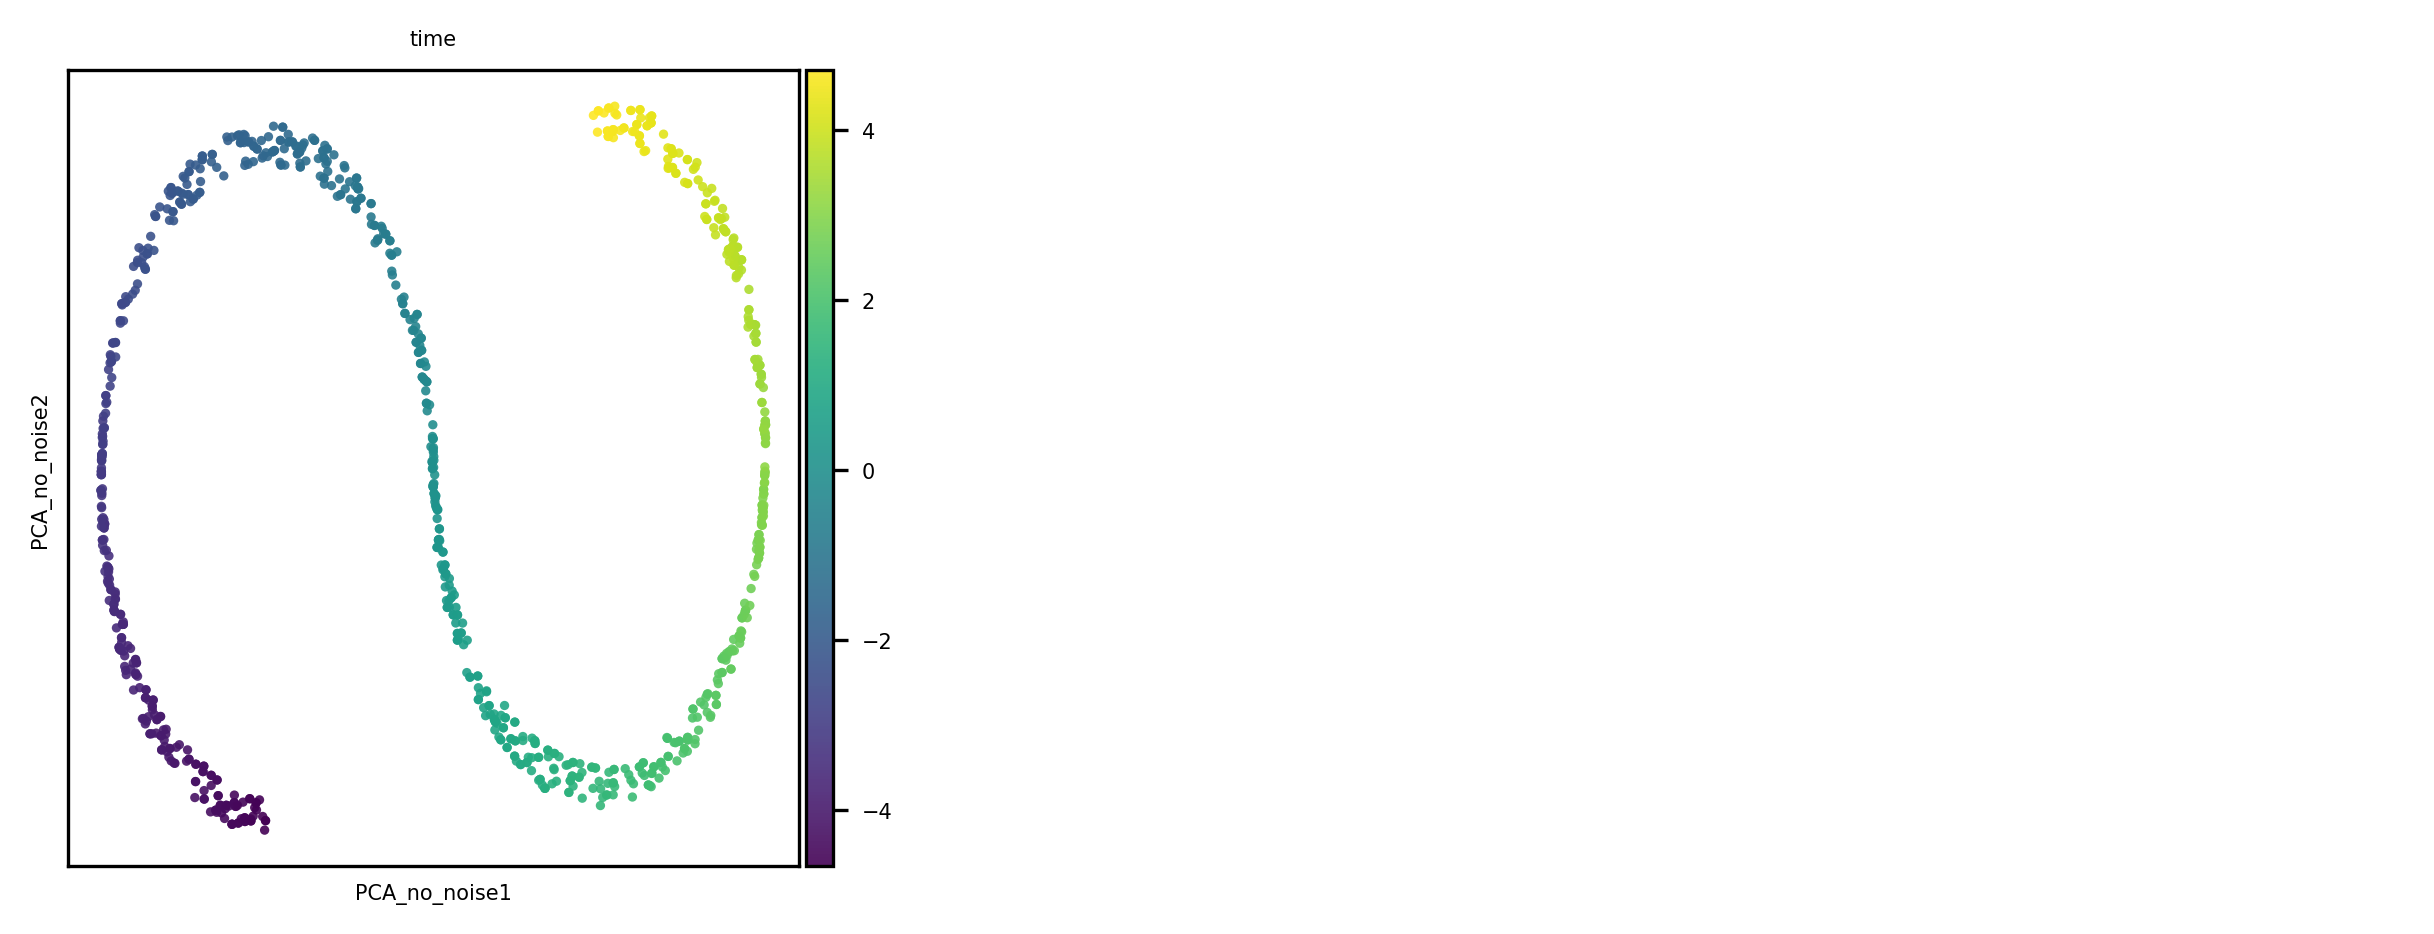

In [132]:
show_basis = 'PCA_no_noise'
show_cols = [group_key]

ccd.pl.plot_embedding(
    adata_state, show_basis, show_cols, figsize=(8,3), dpi=300, ncols=3, font_size=5, point_size=20, legend_loc='on data',
    save_path=save_dir / f"nobatch_{show_basis}_{file_suffix}.png"
)

In [133]:
ccd.pl.plot_embedding_3d(
    adata_state, basis=show_basis, color_by=show_cols,
    save_path= save_dir / f"{show_basis}_{file_suffix}.html",
    point_size=3, opacity=0.8, width=1000, height=800
)

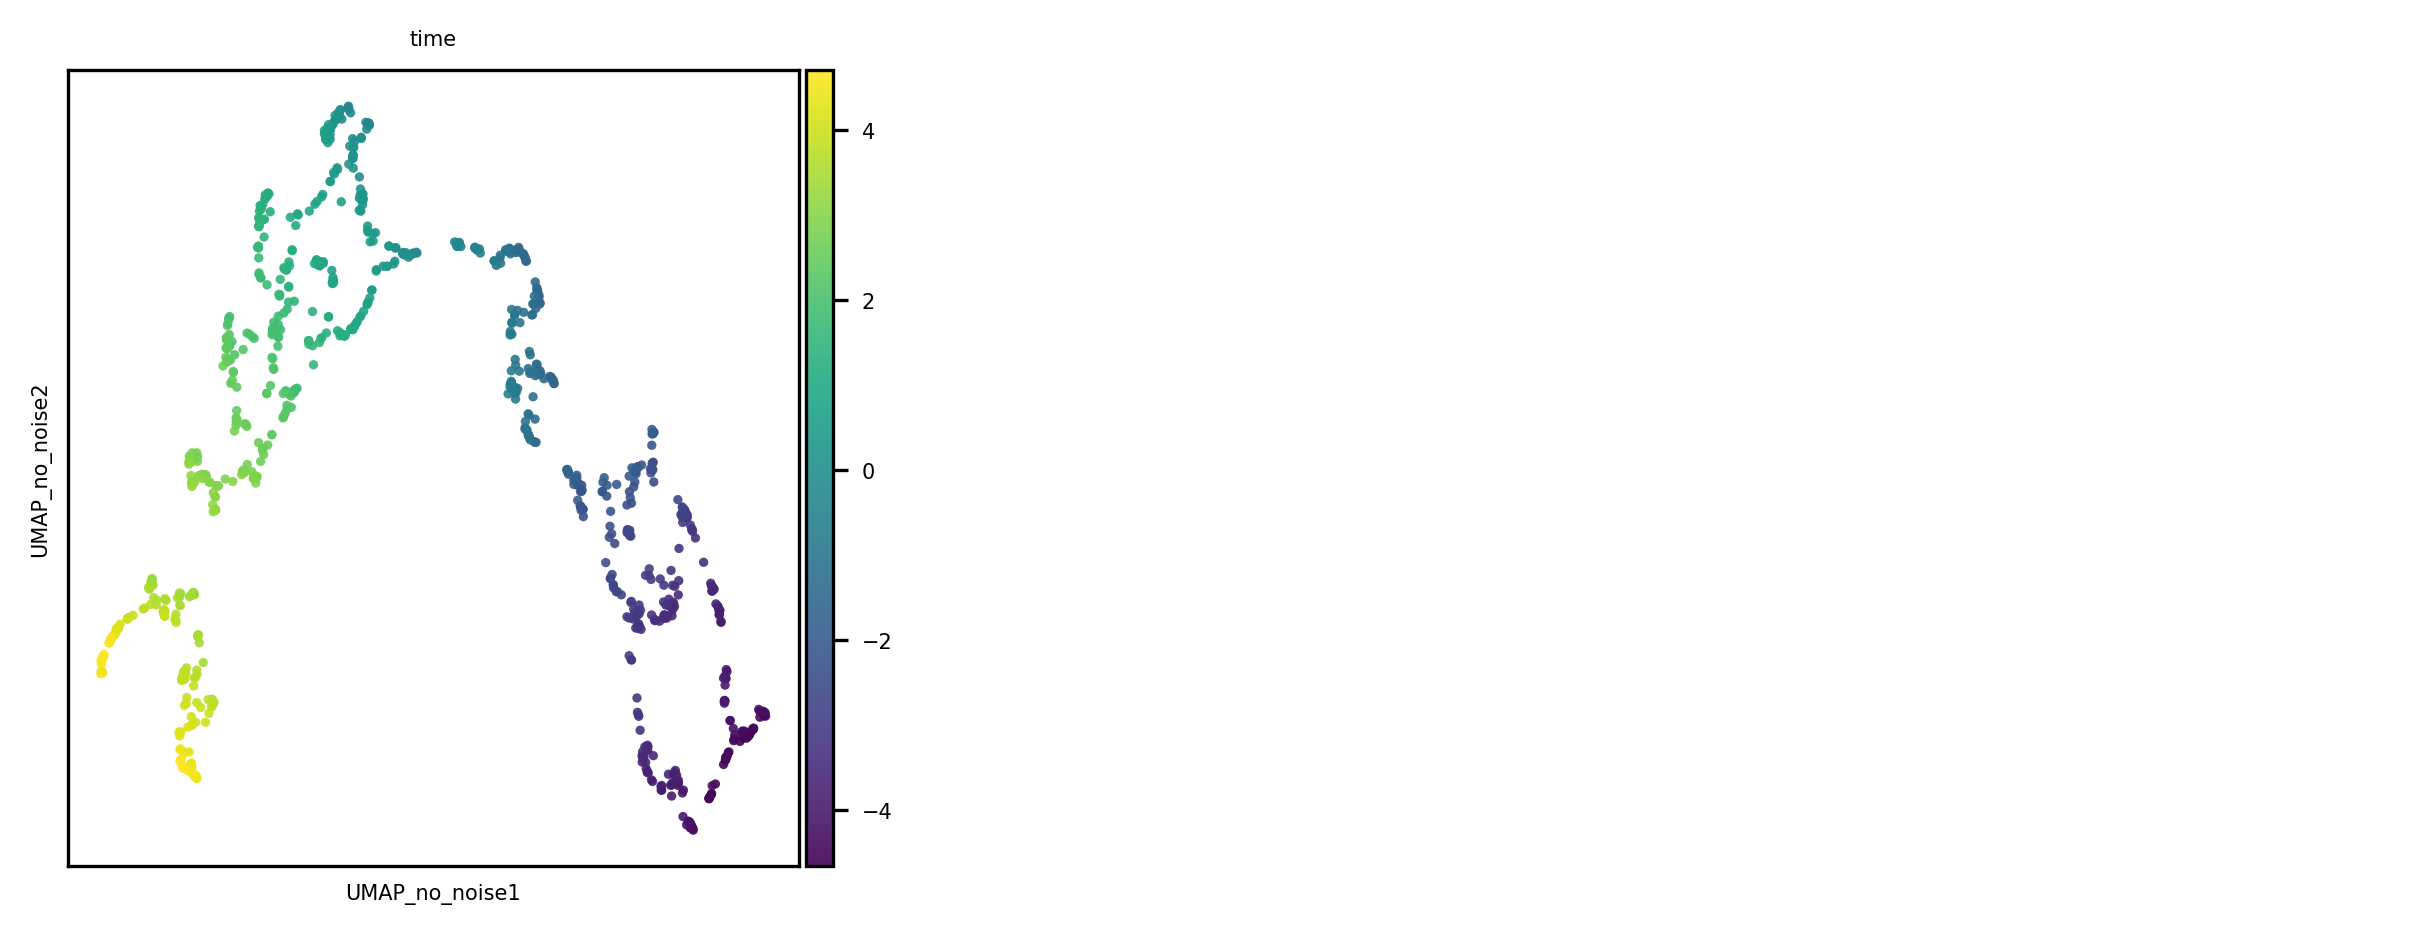

In [134]:
show_basis = 'UMAP_no_noise'
show_cols = [group_key]

ccd.pl.plot_embedding(
    adata_state, show_basis, show_cols, figsize=(8,3), dpi=300, ncols=3, font_size=5, point_size=20, legend_loc='on data',
    save_path=save_dir / f"nobatch_{show_basis}_{file_suffix}.png"
)

### NO batch effect, noise added, PCA and UMAP

In [135]:
adata_state.X = adata_state.layers['wt_noise'].copy()
ccd.ul.run_pca(adata_state, source_key='wt_noise', result_key='PCA_wt_noise', n_pc=30, random_state=seed)
ccd.ul.run_umap(adata_state, source_key='PCA_wt_noise', result_key='UMAP_wt_noise', random_state=seed)

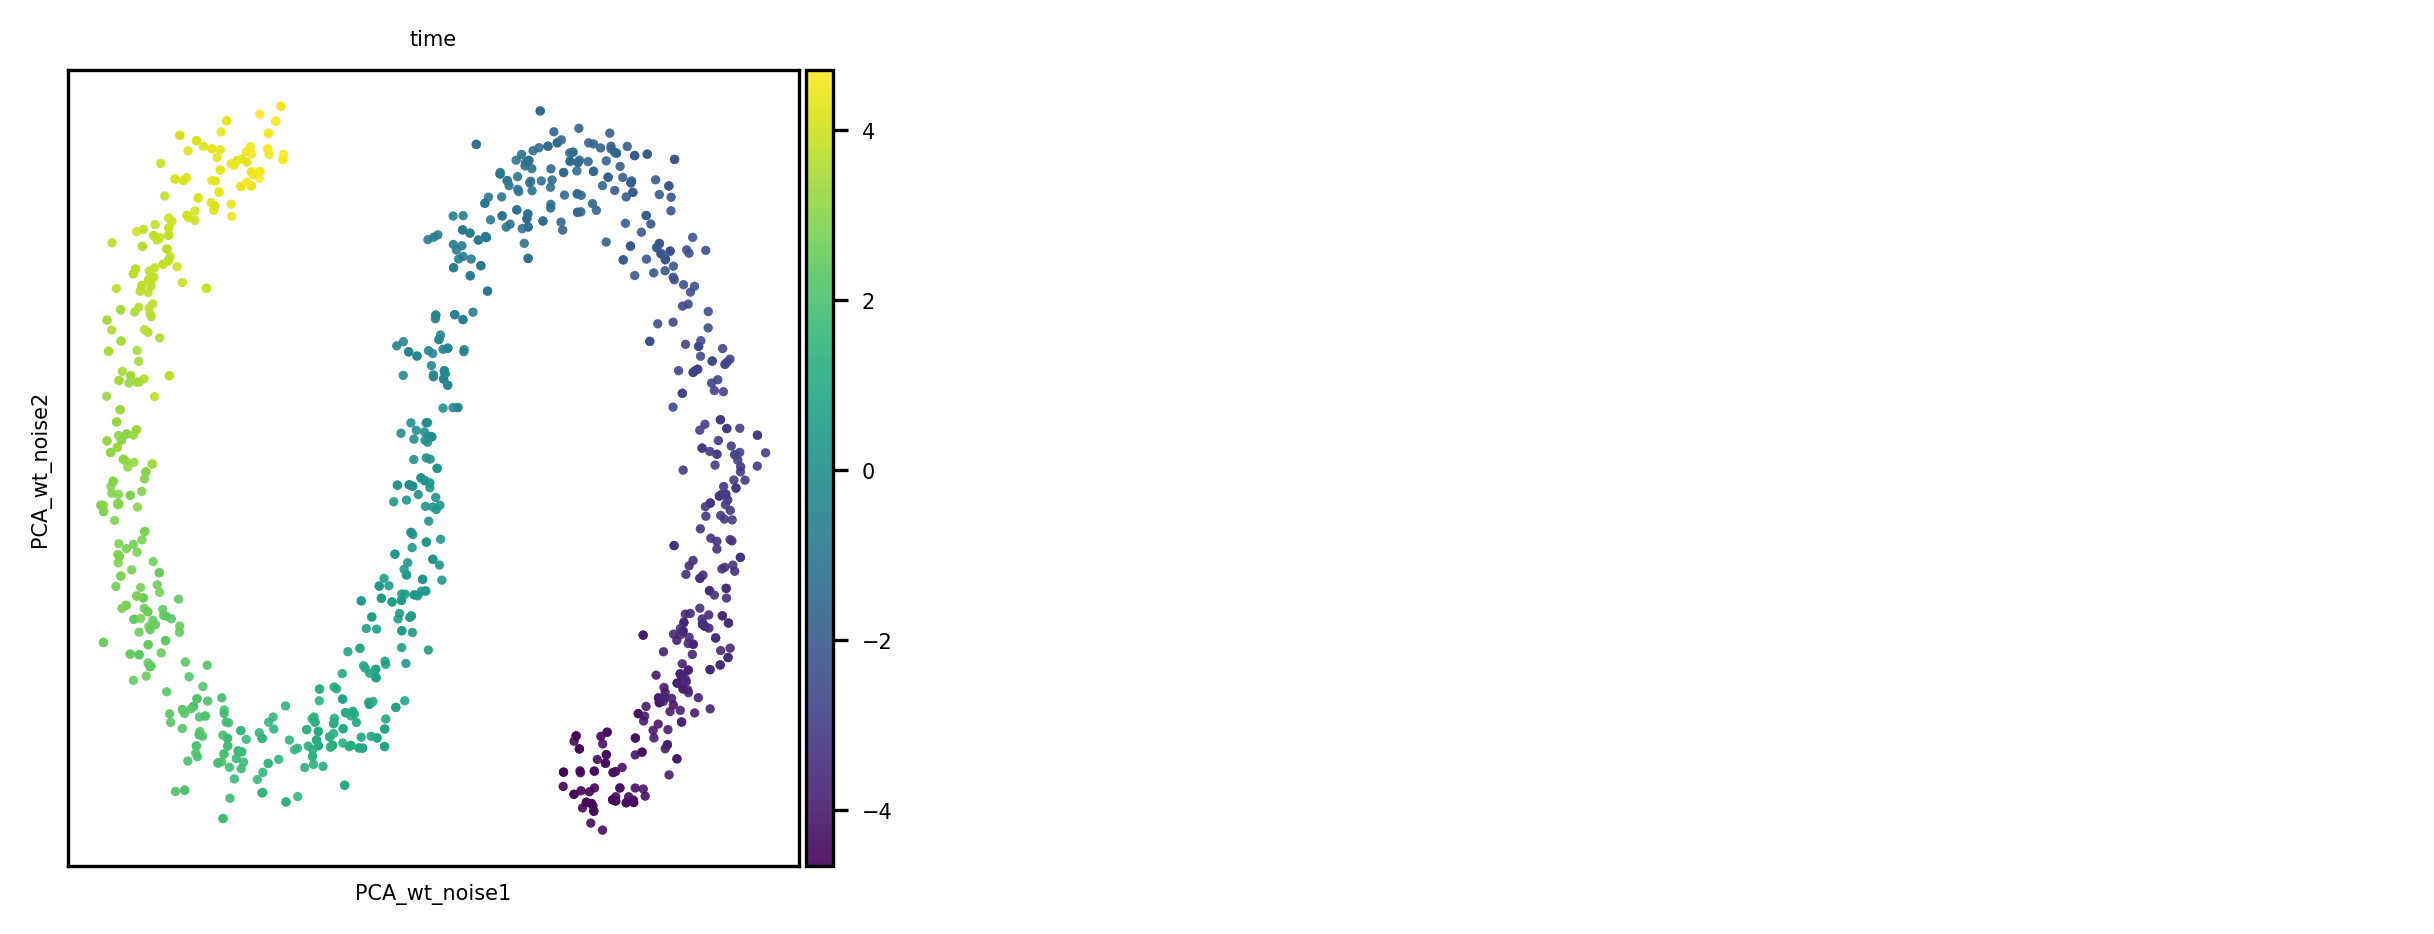

In [136]:
show_basis = 'PCA_wt_noise'
show_cols = [group_key]

ccd.pl.plot_embedding(
    adata_state, show_basis, show_cols, figsize=(8,3), dpi=300, ncols=3, font_size=5, point_size=20, legend_loc='on data',
    save_path=save_dir / f"nobatch_{show_basis}_{file_suffix}.png"
)

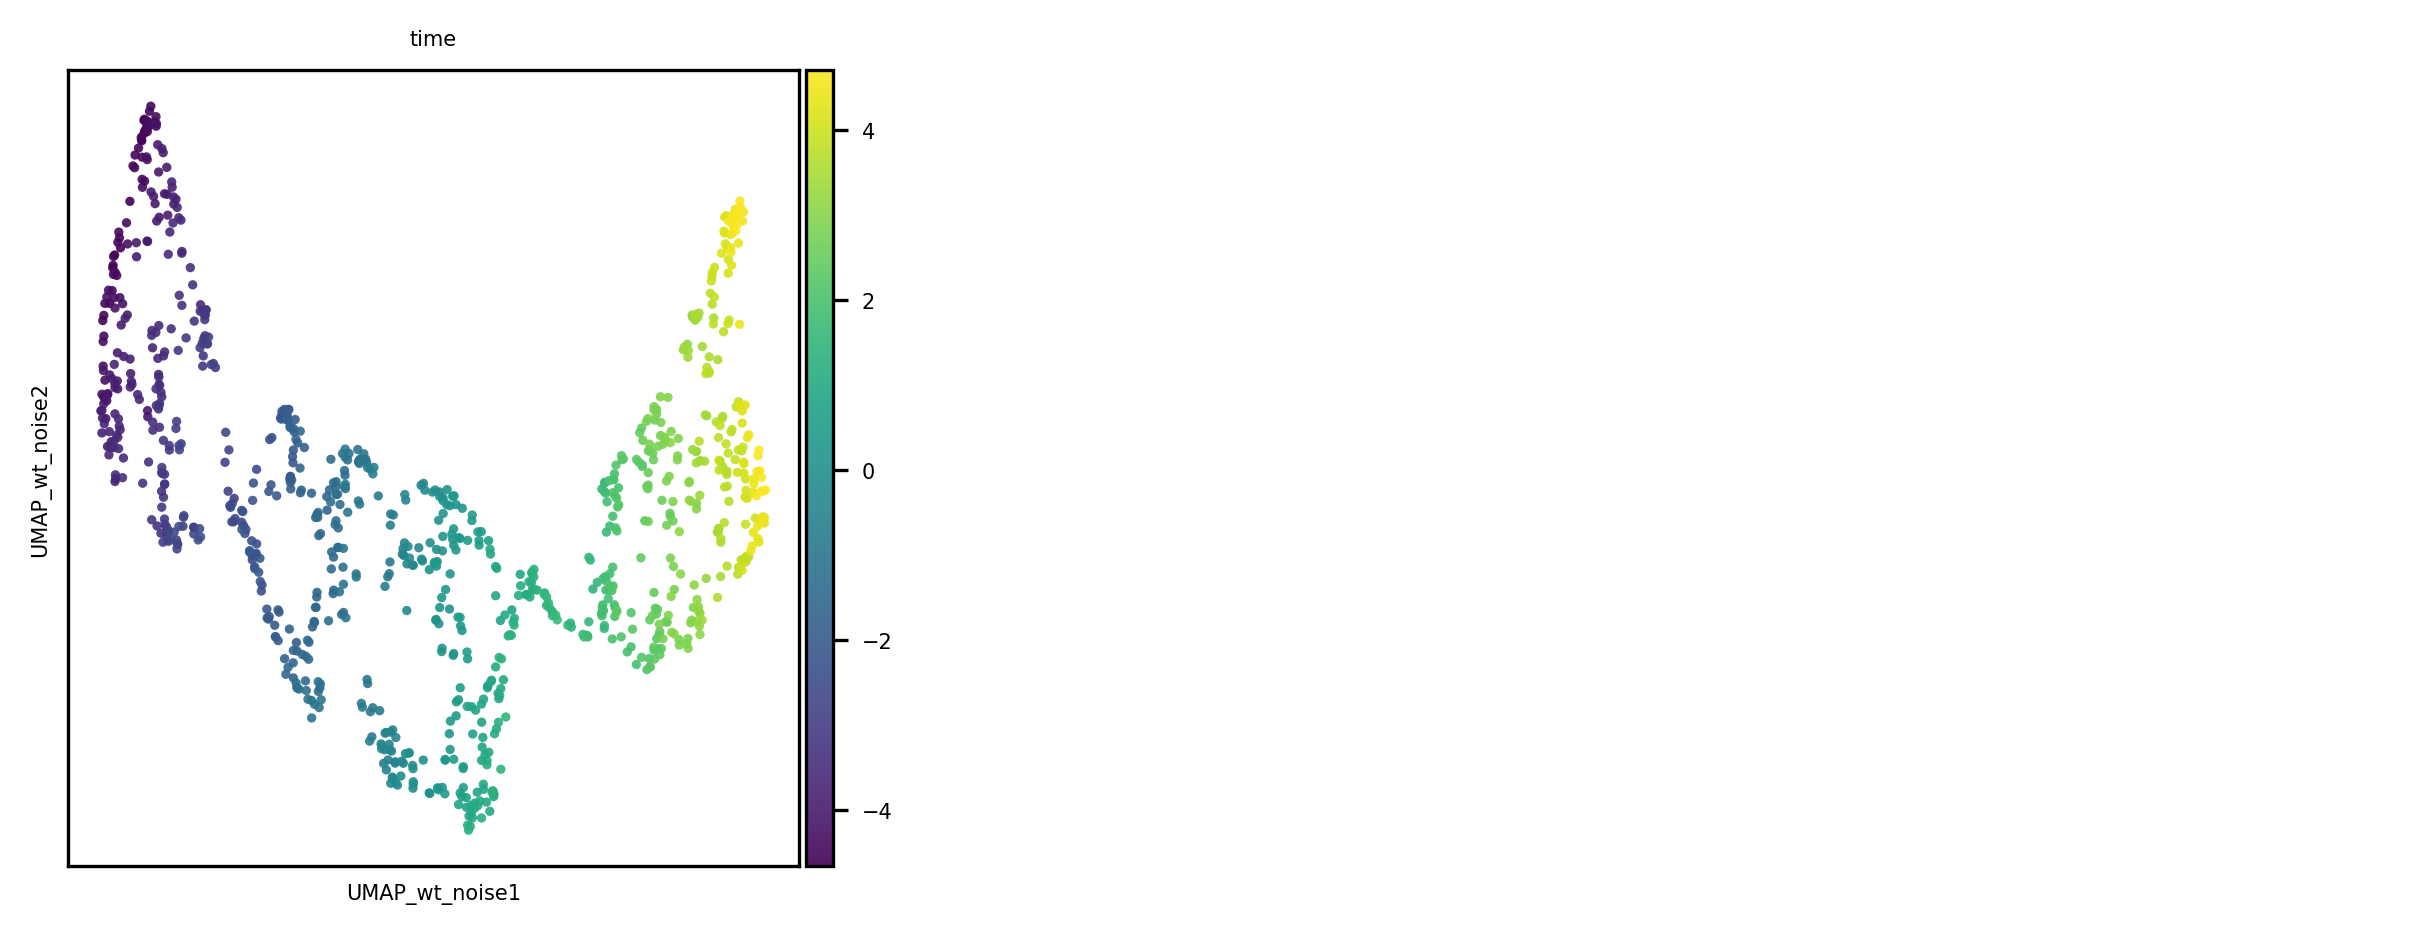

In [137]:
show_basis = 'UMAP_wt_noise'
show_cols = [group_key]

ccd.pl.plot_embedding(
    adata_state, show_basis, show_cols, figsize=(8,3), dpi=300, ncols=3, font_size=5, point_size=20, legend_loc='on data',
    save_path=save_dir / f"nobatch_{show_basis}_{file_suffix}.png"
)

### No batch correction, PCA and UMAP

In [138]:
n_pcs = min(adata.n_obs, adata.n_vars)-1
sc.pp.pca(adata, n_comps=n_pcs)
sc.pp.neighbors(adata, n_neighbors=30, n_pcs=n_pcs)
sc.tl.umap(adata, min_dist=0.5)
adata.obsm["Unintegrated"] = adata.obsm["X_pca"]

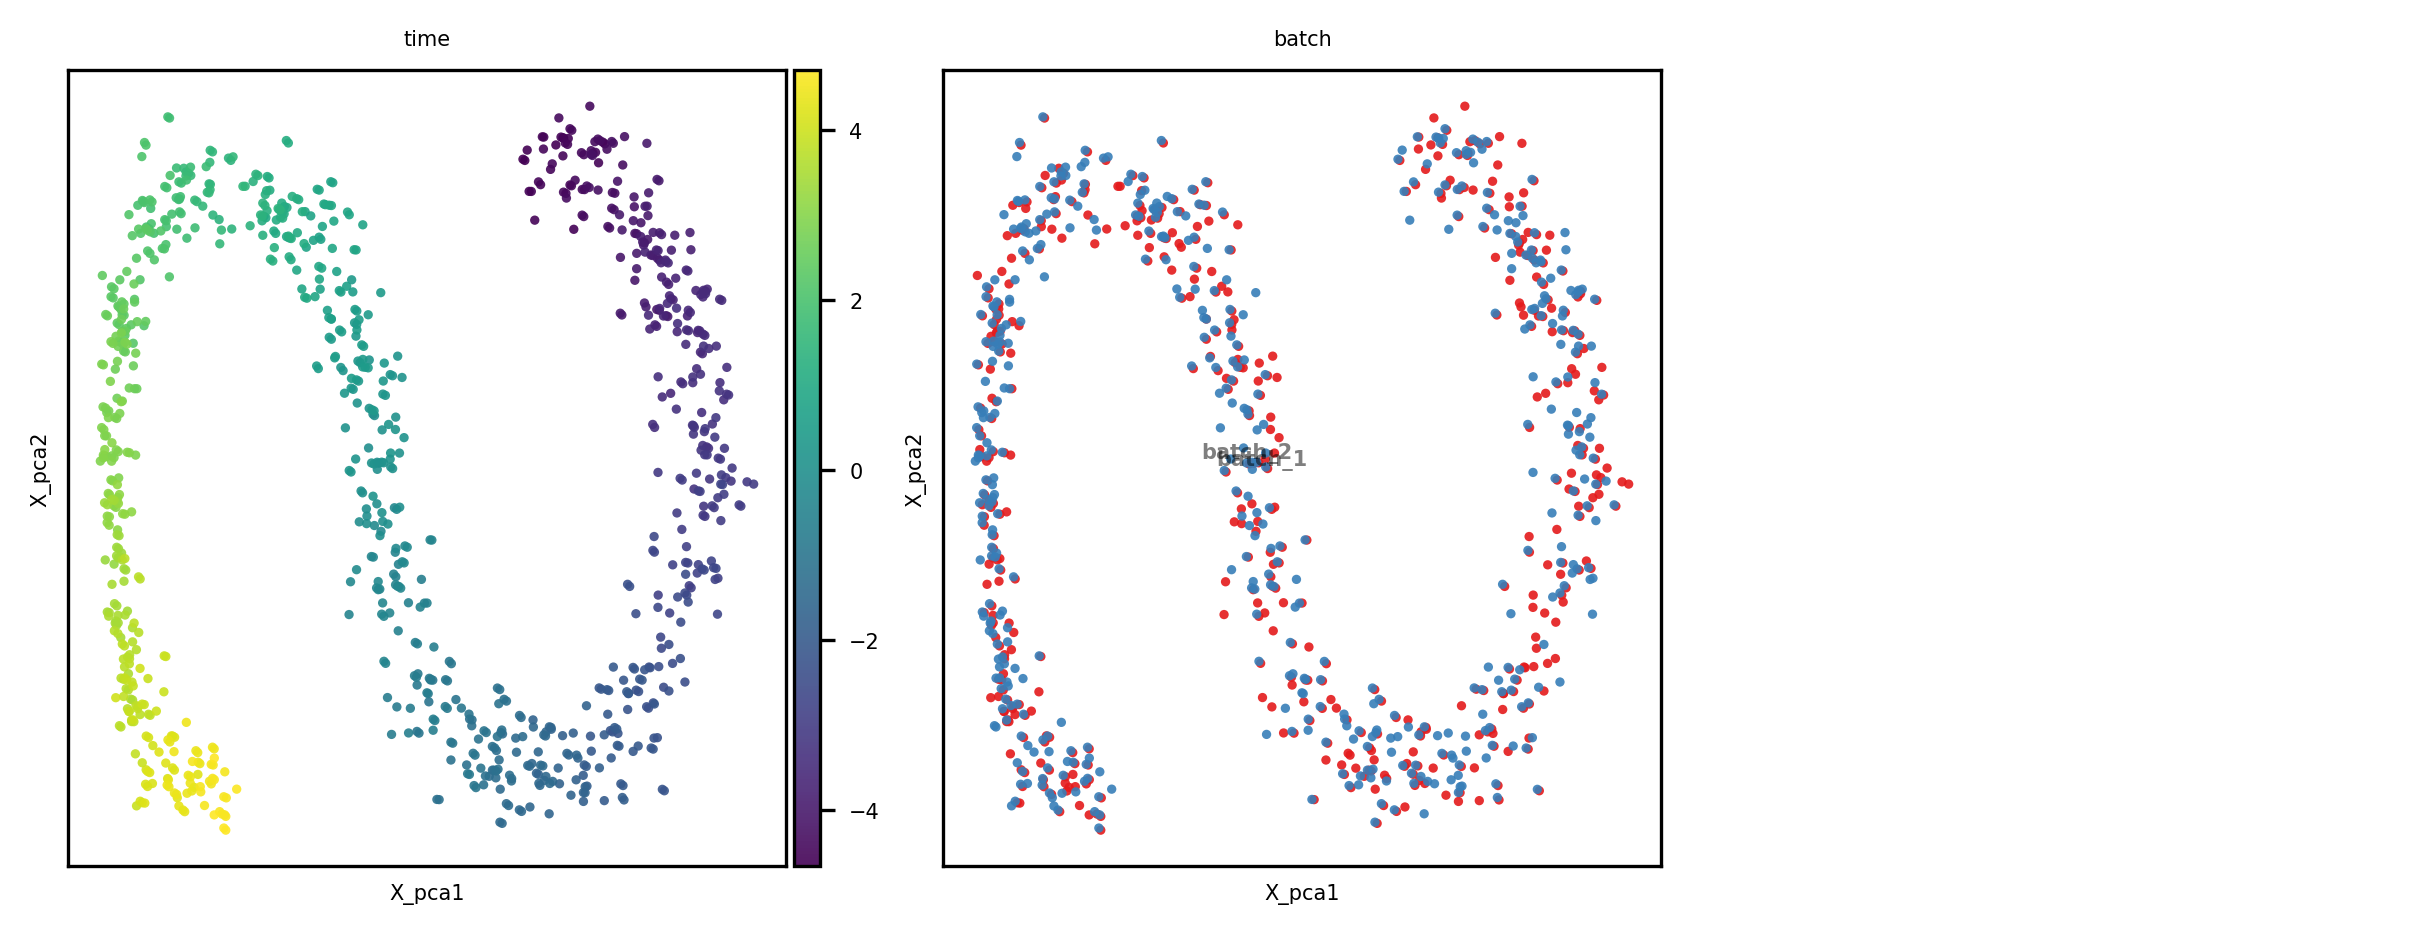

In [139]:
show_basis = 'X_pca'
show_cols = [group_key, batch_key]

ccd.pl.plot_embedding(
    adata, show_basis, show_cols, figsize=(8,3), dpi=300, ncols=3, font_size=5, point_size=20, legend_loc='on data',
    save_path=save_dir / f"wtbatch_{show_basis}_{file_suffix}.png"
)

In [140]:
ccd.pl.plot_embedding_3d(
    adata, basis=show_basis, color_by=show_cols,
    save_path= save_dir / f"{show_basis}_{file_suffix}.html",
    point_size=3, opacity=0.8, width=1000, height=800
)

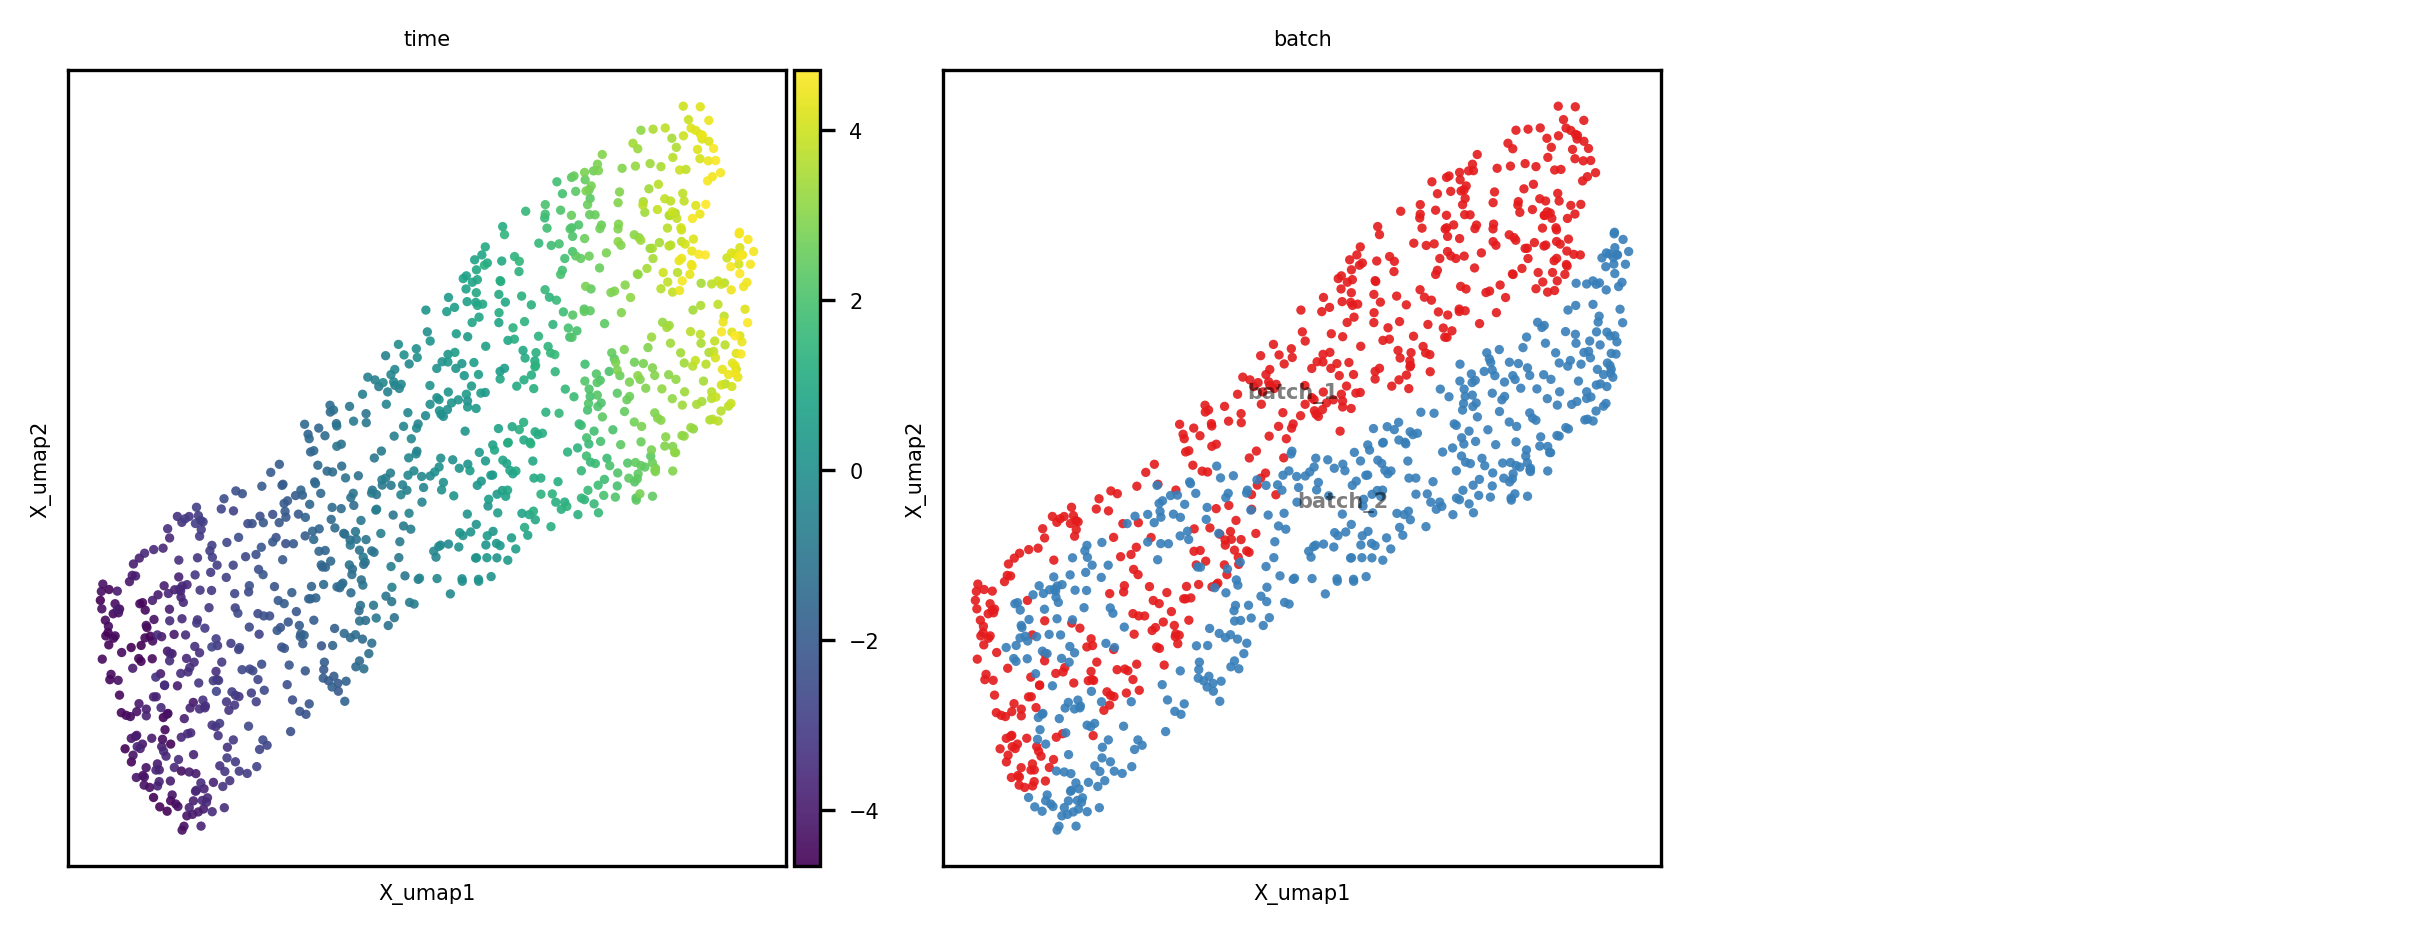

In [141]:
show_basis = 'X_umap'
ccd.pl.plot_embedding(
    adata, show_basis, show_cols, figsize=(8,3), dpi=300, ncols=3, font_size=5, point_size=20, legend_loc='on data',
    save_path=save_dir / f"wtbatch_{show_basis}_{file_suffix}.png"
)

## Concord

In [142]:
cur_ccd = ccd.Concord(adata=adata, 
                      input_feature=None, 
                      batch_size=32,
                      n_epochs=10,
                      lr=1e-2,
                      train_frac=1.0,
                      schedule_ratio = 0.97,
                      latent_dim=32, # latent dimension
                      encoder_dims = [64], # encoder architecture
                      decoder_dims = [64], # decoder architecture
                      norm_type = 'layer_norm',
                      use_importance_mask=False,
                      #importance_penalty_weight=1.0,
                      use_decoder=False,
                      domain_embedding_dim=8,
                      domain_key=batch_key, # key indicating batch
                      augmentation_mask_prob = 0.5, # augmentation mask probability, recommend between 0.1 and 0.7
                      clr_temperature = 0.5, # temperature for NT-Xent loss
                      seed=seed, # random seed
                      p_intra_domain = 1.0, # probability of intra-domain sampling
                      p_intra_knn=0.3,
                      use_faiss=False,
                      sampler_knn = adata.n_obs//10,
                      verbose=False, # print training progress
                      inplace=True, # whether to modify original adata, set to False if you want to keep all expressions
                      device=device, # device to run on
                      save_dir=save_dir # directory to save model checkpoints
                      ) 

# Encode data, saving the latent embedding in adata.obsm['Concord']
output_key = 'Concord'
cur_ccd.encode_adata(input_layer_key='X', output_key=output_key, preprocess=False)
# Save the latent embedding to a file, so that it can be loaded later
ccd.ul.save_obsm_to_hdf5(cur_ccd.adata, save_dir / f"obsm_{file_suffix}.h5")

Concord - WARNING - No input feature list provided. It is recommended to first select features using the command `concord.ul.select_features()`.
p_intra_knn: 0.3


Epoch 0 Training: 30it [00:00, 126.73it/s, loss=3.66]
Epoch 9 Training: 100%|██████████| 30/30 [00:00<00:00, 129.07it/s, loss=3.19]


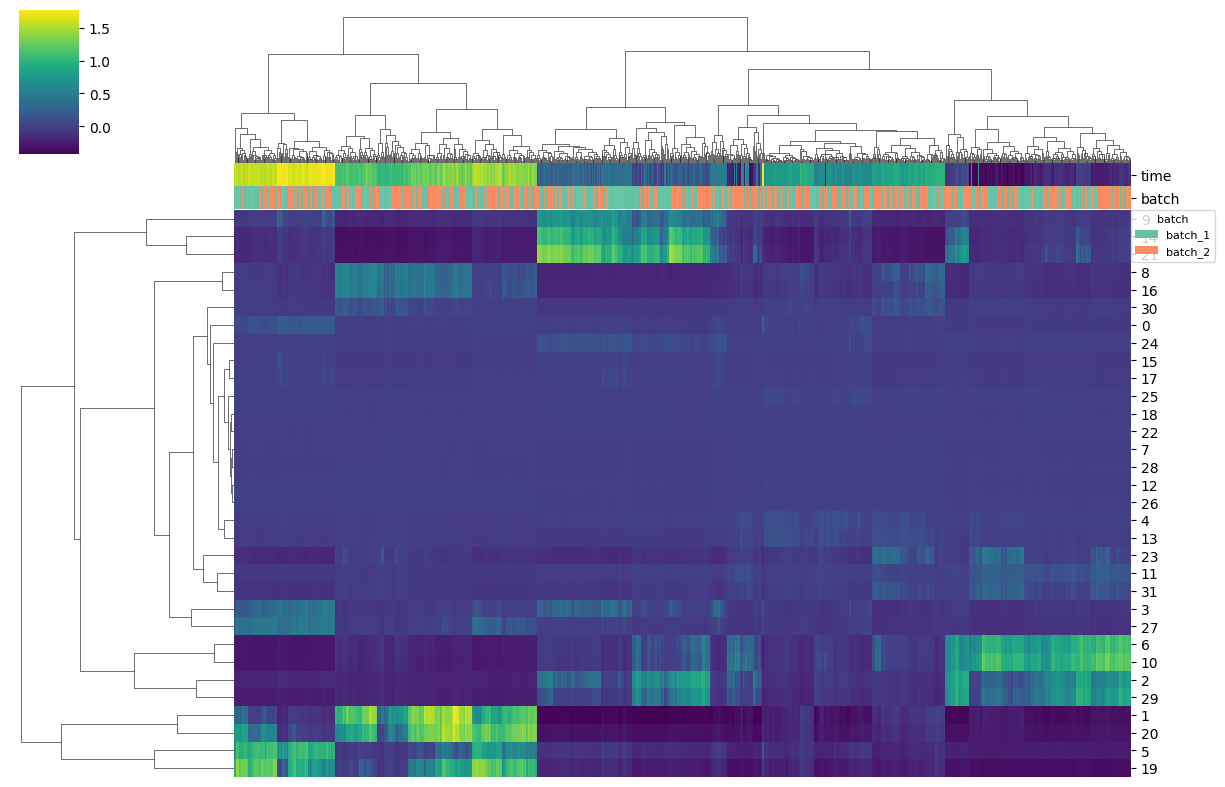

In [143]:
ccd.pl.heatmap_with_annotations(adata, val='Concord', obs_keys=[group_key, batch_key], 
                                cluster_cols=True, cluster_rows=True, cmap='viridis', 
                                pal = {'cluster': 'Set1', 'batch':'Set2'}, add_color_legend=True,
                                save_path=save_dir/f'Concord_latent_heatmap_{file_suffix}.png')

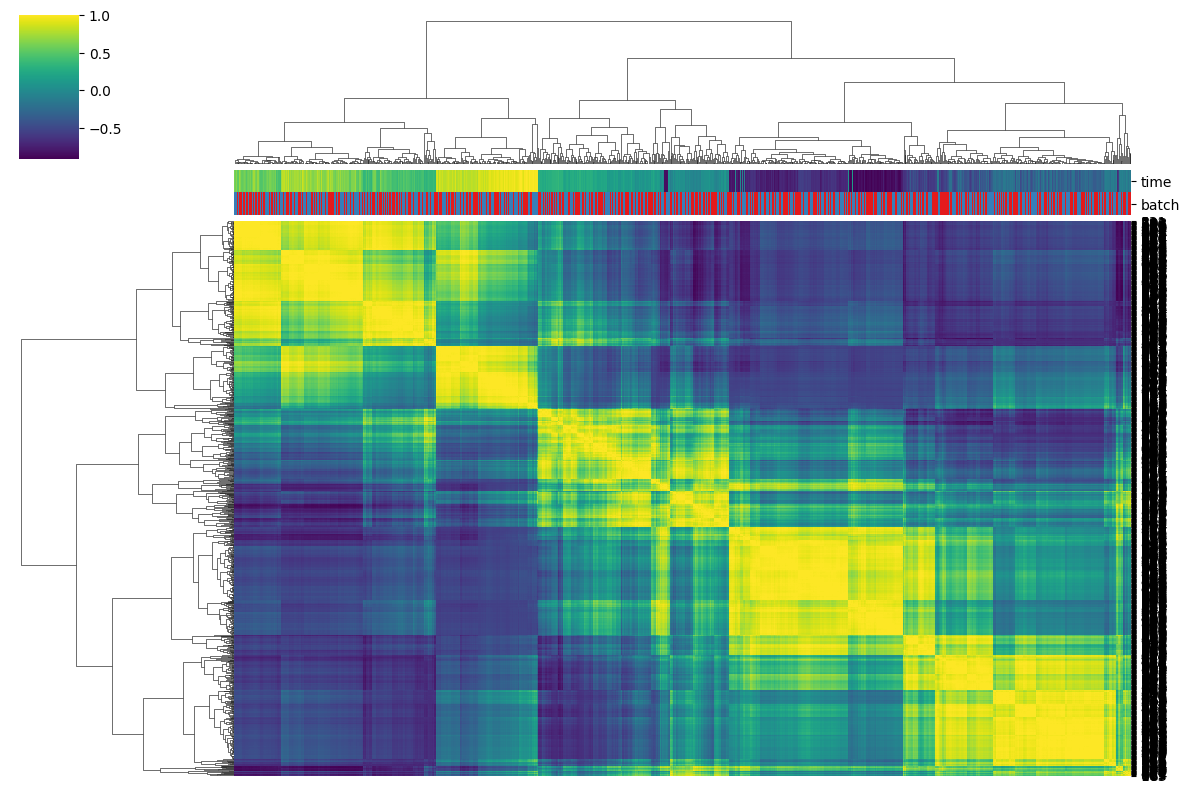

In [144]:
# Compute the correlation matrix
cos_mtx = ccd.ul.cosine_sim(adata.obsm['Concord'])
ccd.pl.heatmap_with_annotations(adata, val=cos_mtx,
                                obs_keys=[group_key, batch_key], cluster_cols=True, cluster_rows=True, cmap='viridis', save_path=save_dir/f'Concord_cosine_{file_suffix}.png')

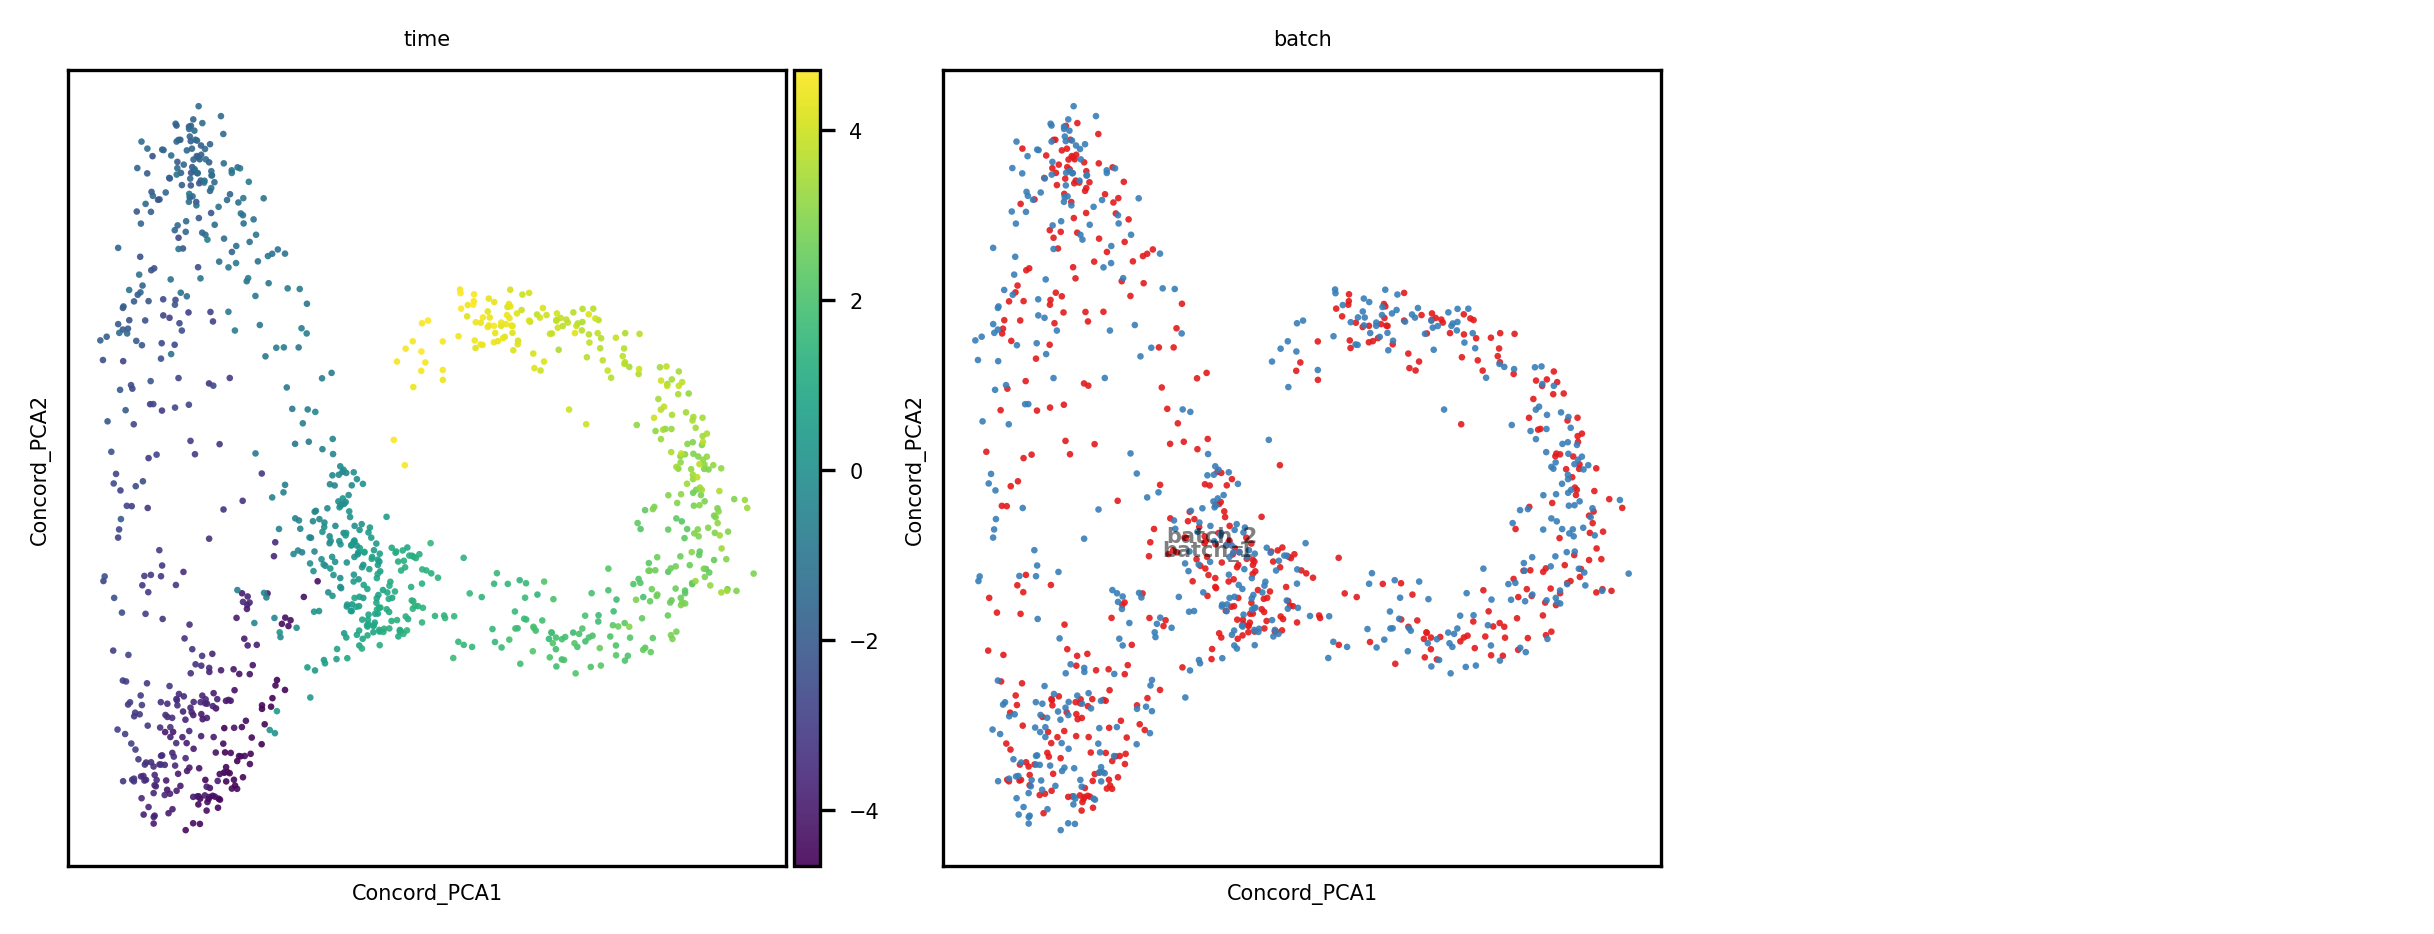

In [145]:
n_pc = min(adata.obsm[output_key].shape[1], adata.shape[0]) - 1
ccd.ul.run_pca(adata, source_key=output_key, result_key=f'{output_key}_PCA', n_pc=n_pc, random_state=seed)
show_basis = f'{output_key}_PCA'
show_cols = [group_key, batch_key]
ccd.pl.plot_embedding(
    adata, show_basis, show_cols, figsize=(8,3), dpi=300, ncols=3, font_size=5, point_size=10, legend_loc='on data',
    save_path=save_dir / f"{show_basis}_{file_suffix}.png"
)

In [146]:
ccd.pl.plot_embedding_3d(
    adata, basis=show_basis, color_by=show_cols,
    save_path= save_dir / f"{show_basis}_{file_suffix}.html",
    point_size=3, opacity=0.8, width=1000, height=800
)

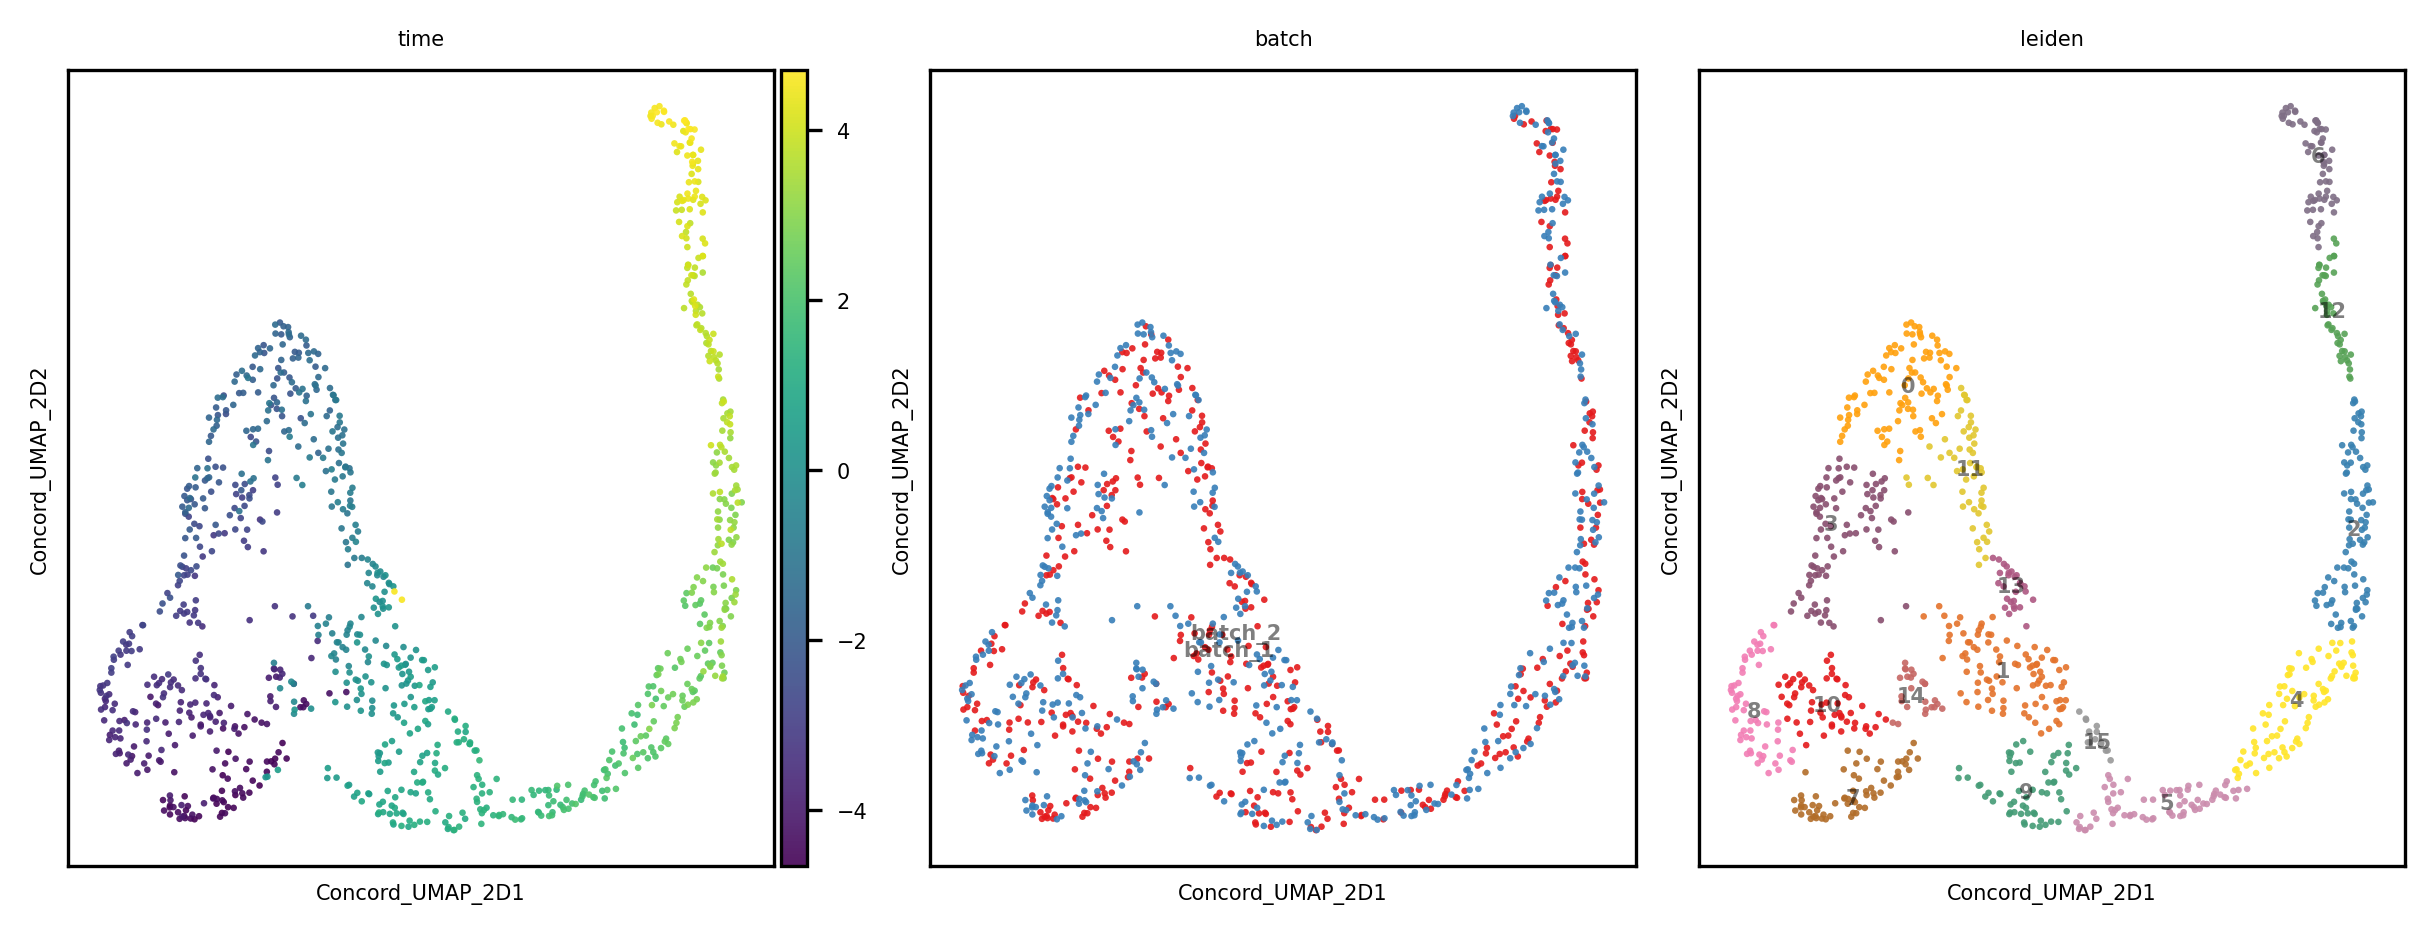

In [147]:
sc.pp.neighbors(adata, n_neighbors=30, use_rep = 'Concord')
ccd.ul.run_umap(adata, source_key='Concord', result_key='Concord_UMAP_2D', n_components=2, n_neighbors=30, min_dist=0.5, metric='euclidean', random_state=seed)
sc.tl.leiden(adata, resolution=1.0)
show_cols = [group_key, batch_key, 'leiden']
show_basis = 'Concord_UMAP_2D'   
ccd.pl.plot_embedding(
    adata, show_basis, show_cols, figsize=(8,3), dpi=300, ncols=3, font_size=5, point_size=10, legend_loc='on data',
    save_path=save_dir / f"{show_basis}_{file_suffix}.png"
)


In [150]:
adata.write_h5ad(data_dir / f"adata_{file_suffix}.h5ad") 
adata_state.write_h5ad(data_dir / f"adata_state_{file_suffix}.h5ad")